<a href="https://colab.research.google.com/github/ramziourari/asl-recognition/blob/main/gluestick_matching_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Download the repository
!git clone https://github.com/cvg/GlueStick.git
%cd GlueStick

# Install requirements
!pip install -r requirements.txt
!wget https://github.com/cvg/GlueStick/releases/download/v0.1_arxiv/checkpoint_GlueStick_MD.tar -P resources/weights

fatal: destination path 'GlueStick' already exists and is not an empty directory.
/content/GlueStick
  Cloning https://github.com/iago-suarez/pytlsd.git (to revision 37ac583) to /tmp/pip-install-uuwpcmy7/pytlsd_e6cedb91daa247df8ebecffe7f22c55a
  Running command git clone --filter=blob:none --quiet https://github.com/iago-suarez/pytlsd.git /tmp/pip-install-uuwpcmy7/pytlsd_e6cedb91daa247df8ebecffe7f22c55a
  Running command git checkout -q 37ac583
  Resolved https://github.com/iago-suarez/pytlsd.git to commit 37ac583
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-02-07 21:34:52--  https://github.com/cvg/GlueStick/releases/download/v0.1_arxiv/checkpoint_GlueStick_MD.tar
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! pip install geopandas pandas shapely fiona rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.7 MB/s eta 0:00:00


In [7]:
import geopandas as gpd
import pandas as pd
from shapely import box
import fiona
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import rasterio
import matplotlib.pyplot as plt

In [8]:
def read_gpkg_layers_combined(gpkg_path, layer_names):
    """
    Read multiple layers and combine them into a single GeoDataFrame with a 'layer' column

    Args:
        gpkg_path (str): Path to the GeoPackage file
        layer_names (list): List of layer names to read

    Returns:
        GeoDataFrame: Combined GeoDataFrame with all layers
    """
    # Read each layer and add layer name as a column
    gdfs = []
    for layer in layer_names:
        try:
            gdf = gpd.read_file(gpkg_path, layer=layer)
            gdf['layer'] = layer  # Add layer name as a column
            gdfs.append(gdf)
            print(f"Successfully loaded layer: {layer}")
        except Exception as e:
            print(f"Error loading layer {layer}: {str(e)}")

    # Combine all layers into one GeoDataFrame
    combined_gdf = pd.concat(gdfs, ignore_index=True)
    return combined_gdf

In [9]:
from pathlib import Path
STADT = "Stendal"
prefix = "mgb1/"
BASE_PATH = Path(f"/content/drive/MyDrive/data/{STADT}")
gpkg_path = BASE_PATH / "Raw_Data.gpkg"
layers = fiona.listlayers(gpkg_path)
print("Available layers:")
for layer in layers:
    print(f"- {layer}")

Available layers:
- PLANGEBIET
- LAGEPLAENE
- MP_HU
- MP_FG
- ALKIS_HU
- ALKIS_ADRESSE
- ALKIS_FLUR
- MP_TRASSEN
- MP_APL


In [10]:
layers = ["LAGEPLAENE", "ALKIS_HU", "ALKIS_FLUR"]
# Read all layers into a single GeoDataFrame
stadt_df = read_gpkg_layers_combined(gpkg_path, layers)
lp = stadt_df[stadt_df['layer'] == 'LAGEPLAENE']
flur = stadt_df[stadt_df['layer'] == 'ALKIS_FLUR']
haus = stadt_df[stadt_df['layer'] == 'ALKIS_HU']

Successfully loaded layer: LAGEPLAENE
Successfully loaded layer: ALKIS_HU
Successfully loaded layer: ALKIS_FLUR


In [11]:
def get_affine_transformation(tfw_string):
    """Create affine transformation from TFW parameters in pipe-separated string format."""
    tfw_params = [float(x) for x in tfw_string.split('|')]
    xoffset, px_w, rot1, yoffset, rot2, px_h = tfw_params
    geotransform = (xoffset, px_w, rot1, yoffset, rot2, px_h)
    return Affine.from_gdal(*geotransform)

# Create a new column for affine transformation
stadt_df['affine_transform'] = None

# Apply transformation only to LAGEPLAENE rows
mask = stadt_df['layer'] == 'LAGEPLAENE'
stadt_df.loc[mask, 'affine_transform'] = stadt_df.loc[mask, 'TFW'].apply(get_affine_transformation)

# Verify
print("Number of affine transforms created:", stadt_df['affine_transform'].notna().sum())
print("\nExample of first LAGEPLAENE transform:")
print(stadt_df[stadt_df['layer'] == 'LAGEPLAENE']['affine_transform'].iloc[0])

Number of affine transforms created: 211

Example of first LAGEPLAENE transform:
| 0.03, 0.00, 691345.47|
| 0.00,-0.03, 5830844.14|
| 0.00, 0.00, 1.00|


In [12]:
stadt_df

,NAME,TFW,WIDTH,HEIGHT,DATABASE_ID,geometry,layer,FUNKTION,HU_ID,Nutzung,Objektart,affine_transform
0,mgb1/8828ab,691345.4732|0.0317943251|0.001451167847|583084...,7871.0,4295.0,60.0,"POLYGON ((691345.473 5830844.137, 691595.726 5...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.0317943251, 0.001451167847, 691345.4732, 0...."
1,mgb1/8828ad,691351.1187|0.03179182459|0.001271360732|58307...,7865.0,3970.0,60.0,"POLYGON ((691351.119 5830719.339, 691601.161 5...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03179182459, 0.001271360732, 691351.1187, 0..."
2,mgb1/8828ba,691595.848|0.03177956616|0.001306713676|583085...,7859.0,3965.0,60.0,"POLYGON ((691595.848 5830854.41, 691845.604 58...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03177956616, 0.001306713676, 691595.848, 0...."
3,mgb1/8828bb,691845.0007|0.03177973516|0.001466964258|58308...,7877.0,4008.0,60.0,"POLYGON ((691845.001 5830864.799, 692095.33 58...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03177973516, 0.001466964258, 691845.0007, 0..."
4,mgb1/8828bc,691600.9705|0.03178174873|0.001322649449|58307...,7860.0,3975.0,60.0,"POLYGON ((691600.971 5830729.514, 691850.775 5...",LAGEPLAENE,NaN,NaN,NaN,NaN,"(0.03178174873, 0.001322649449, 691600.9705, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
18379,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((694285.227 5832413.659, 694282...",ALKIS_FLUR,NaN,NaN,,Fliessgewaesser,None
18380,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((692851.063 5831839.722, 692831...",ALKIS_FLUR,NaN,NaN,Handel und Dienstleistung,Industrie Und Gewerbeflaeche,None
18381,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((691988.866 5830816.087, 691995...",ALKIS_FLUR,NaN,NaN,,Wohnbauflaeche,None
18382,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((693000.708 5832463.496, 692991...",ALKIS_FLUR,NaN,NaN,,Wohnbauflaeche,None


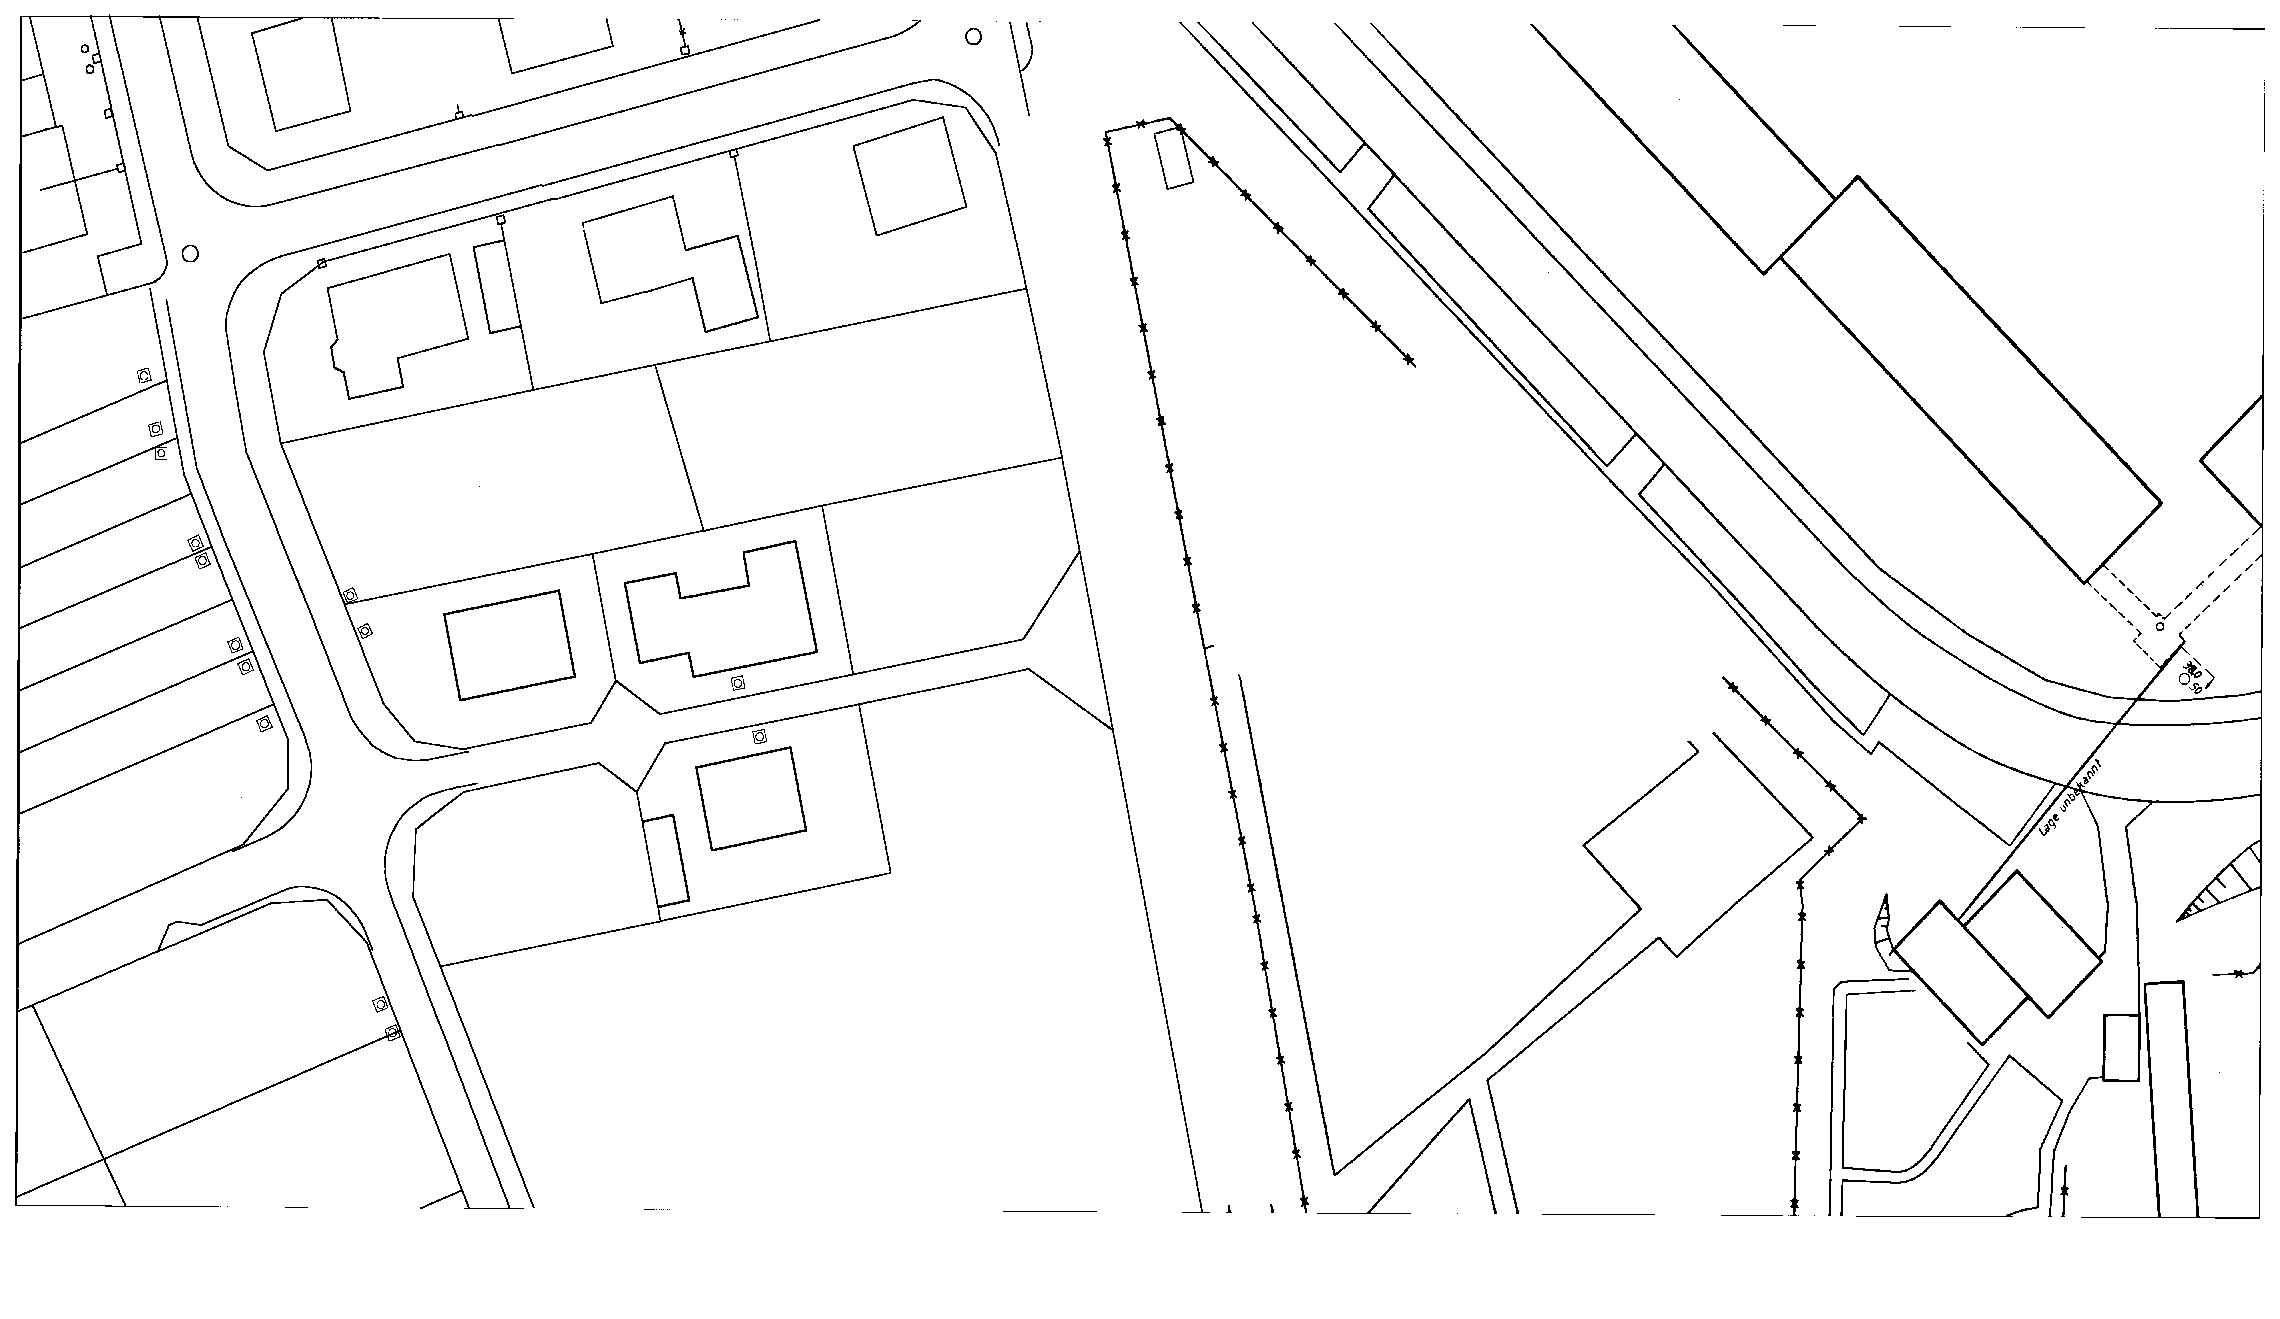

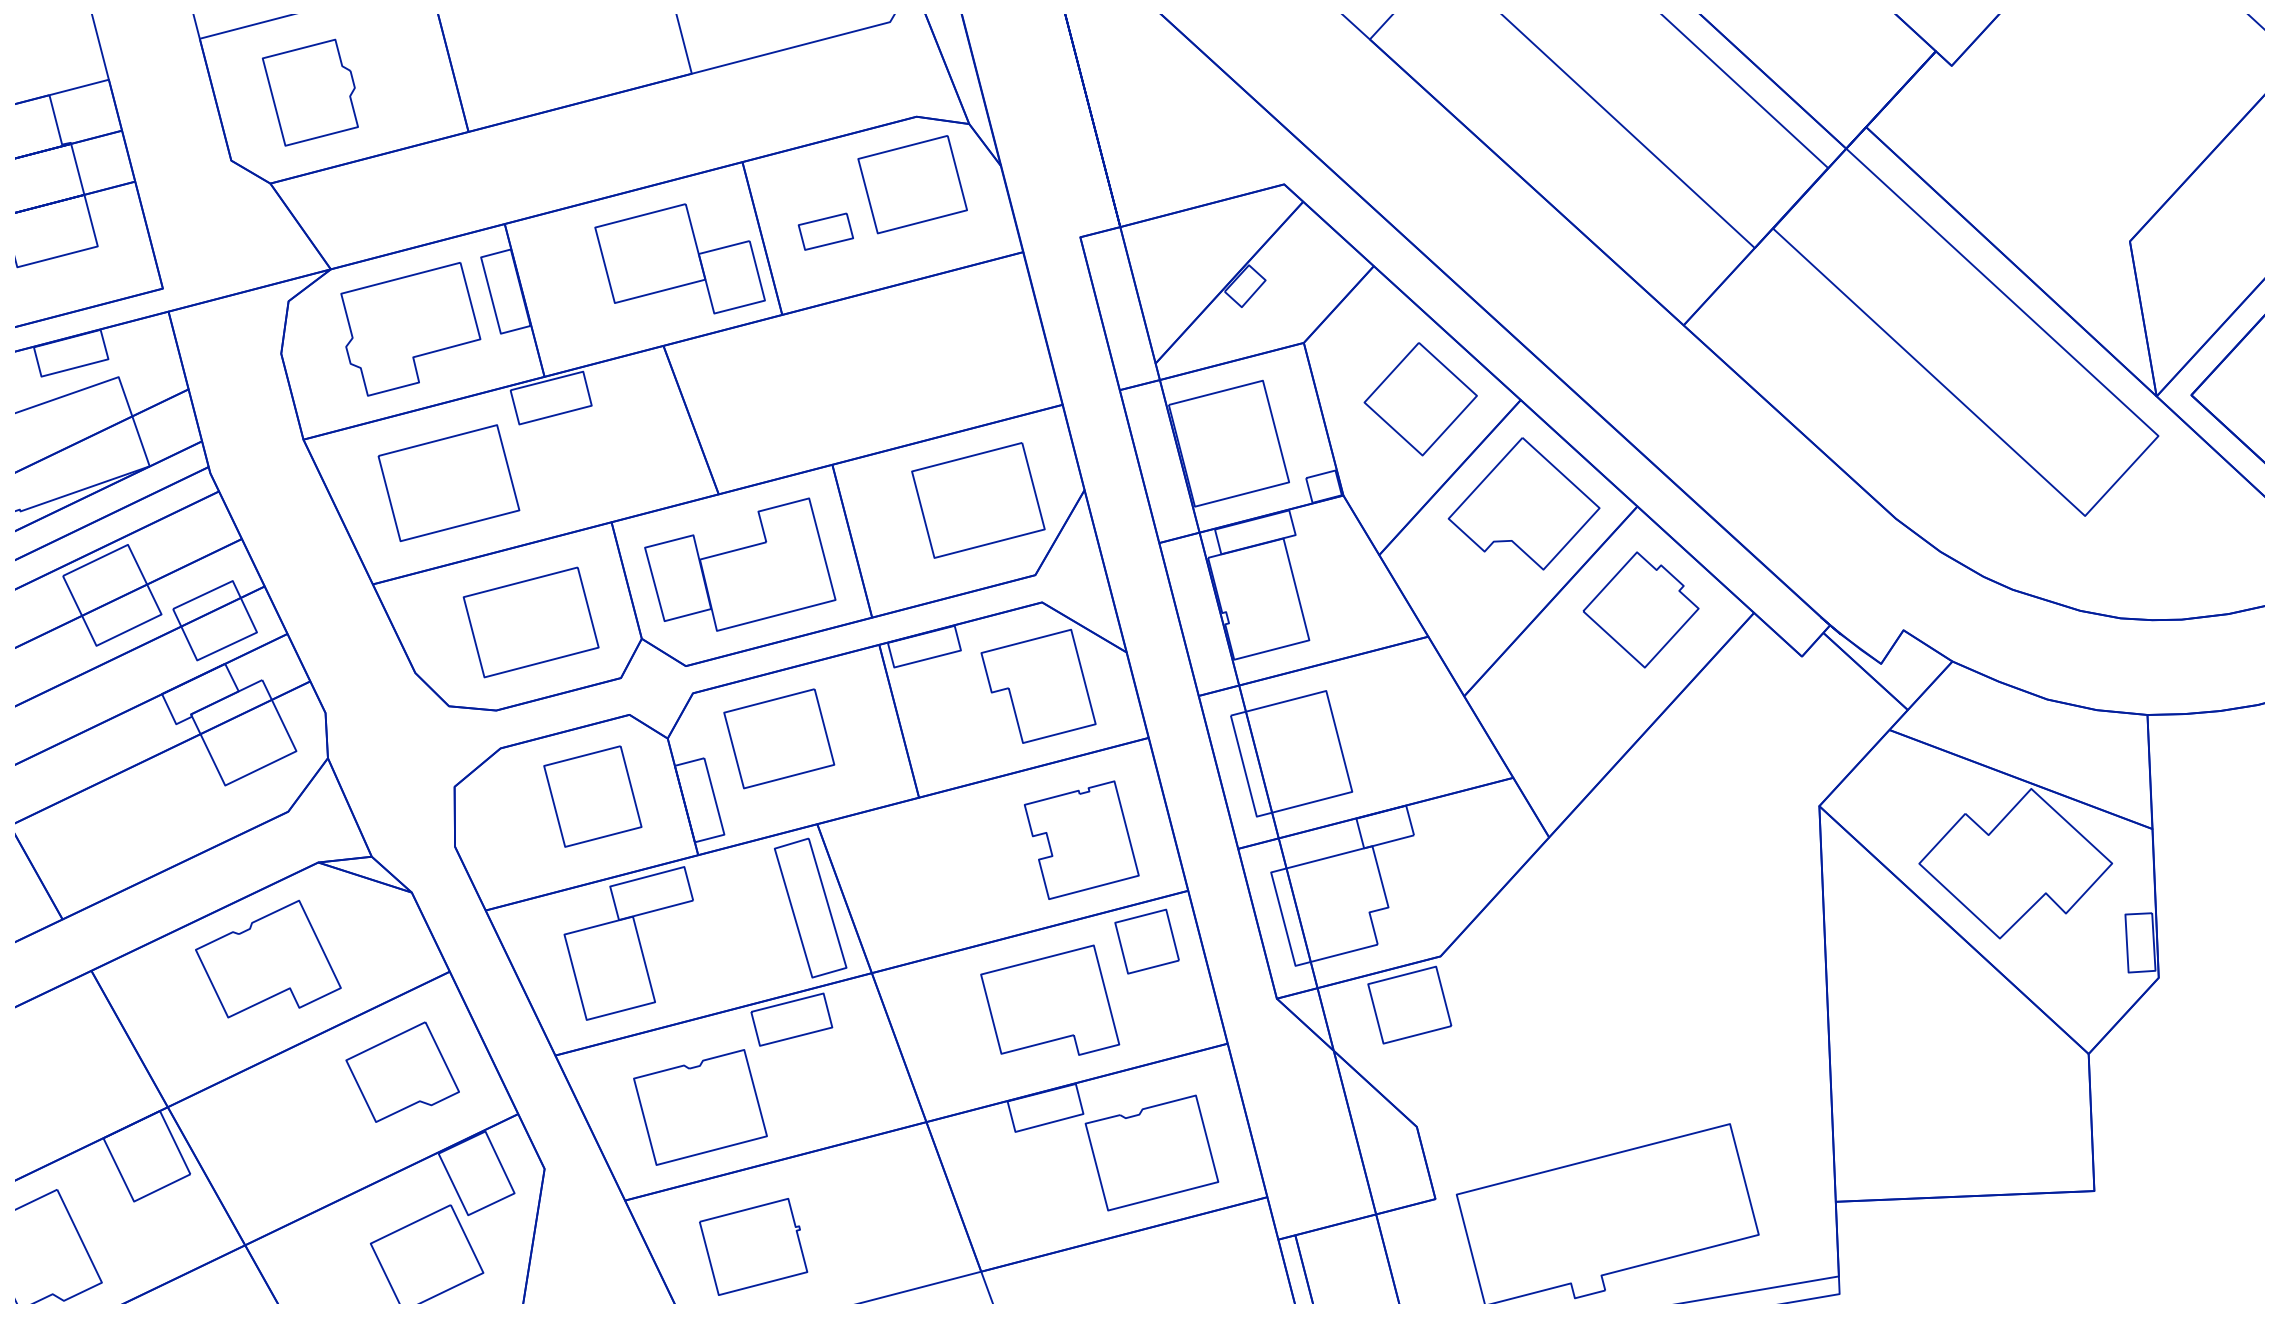

saved raster and alkis


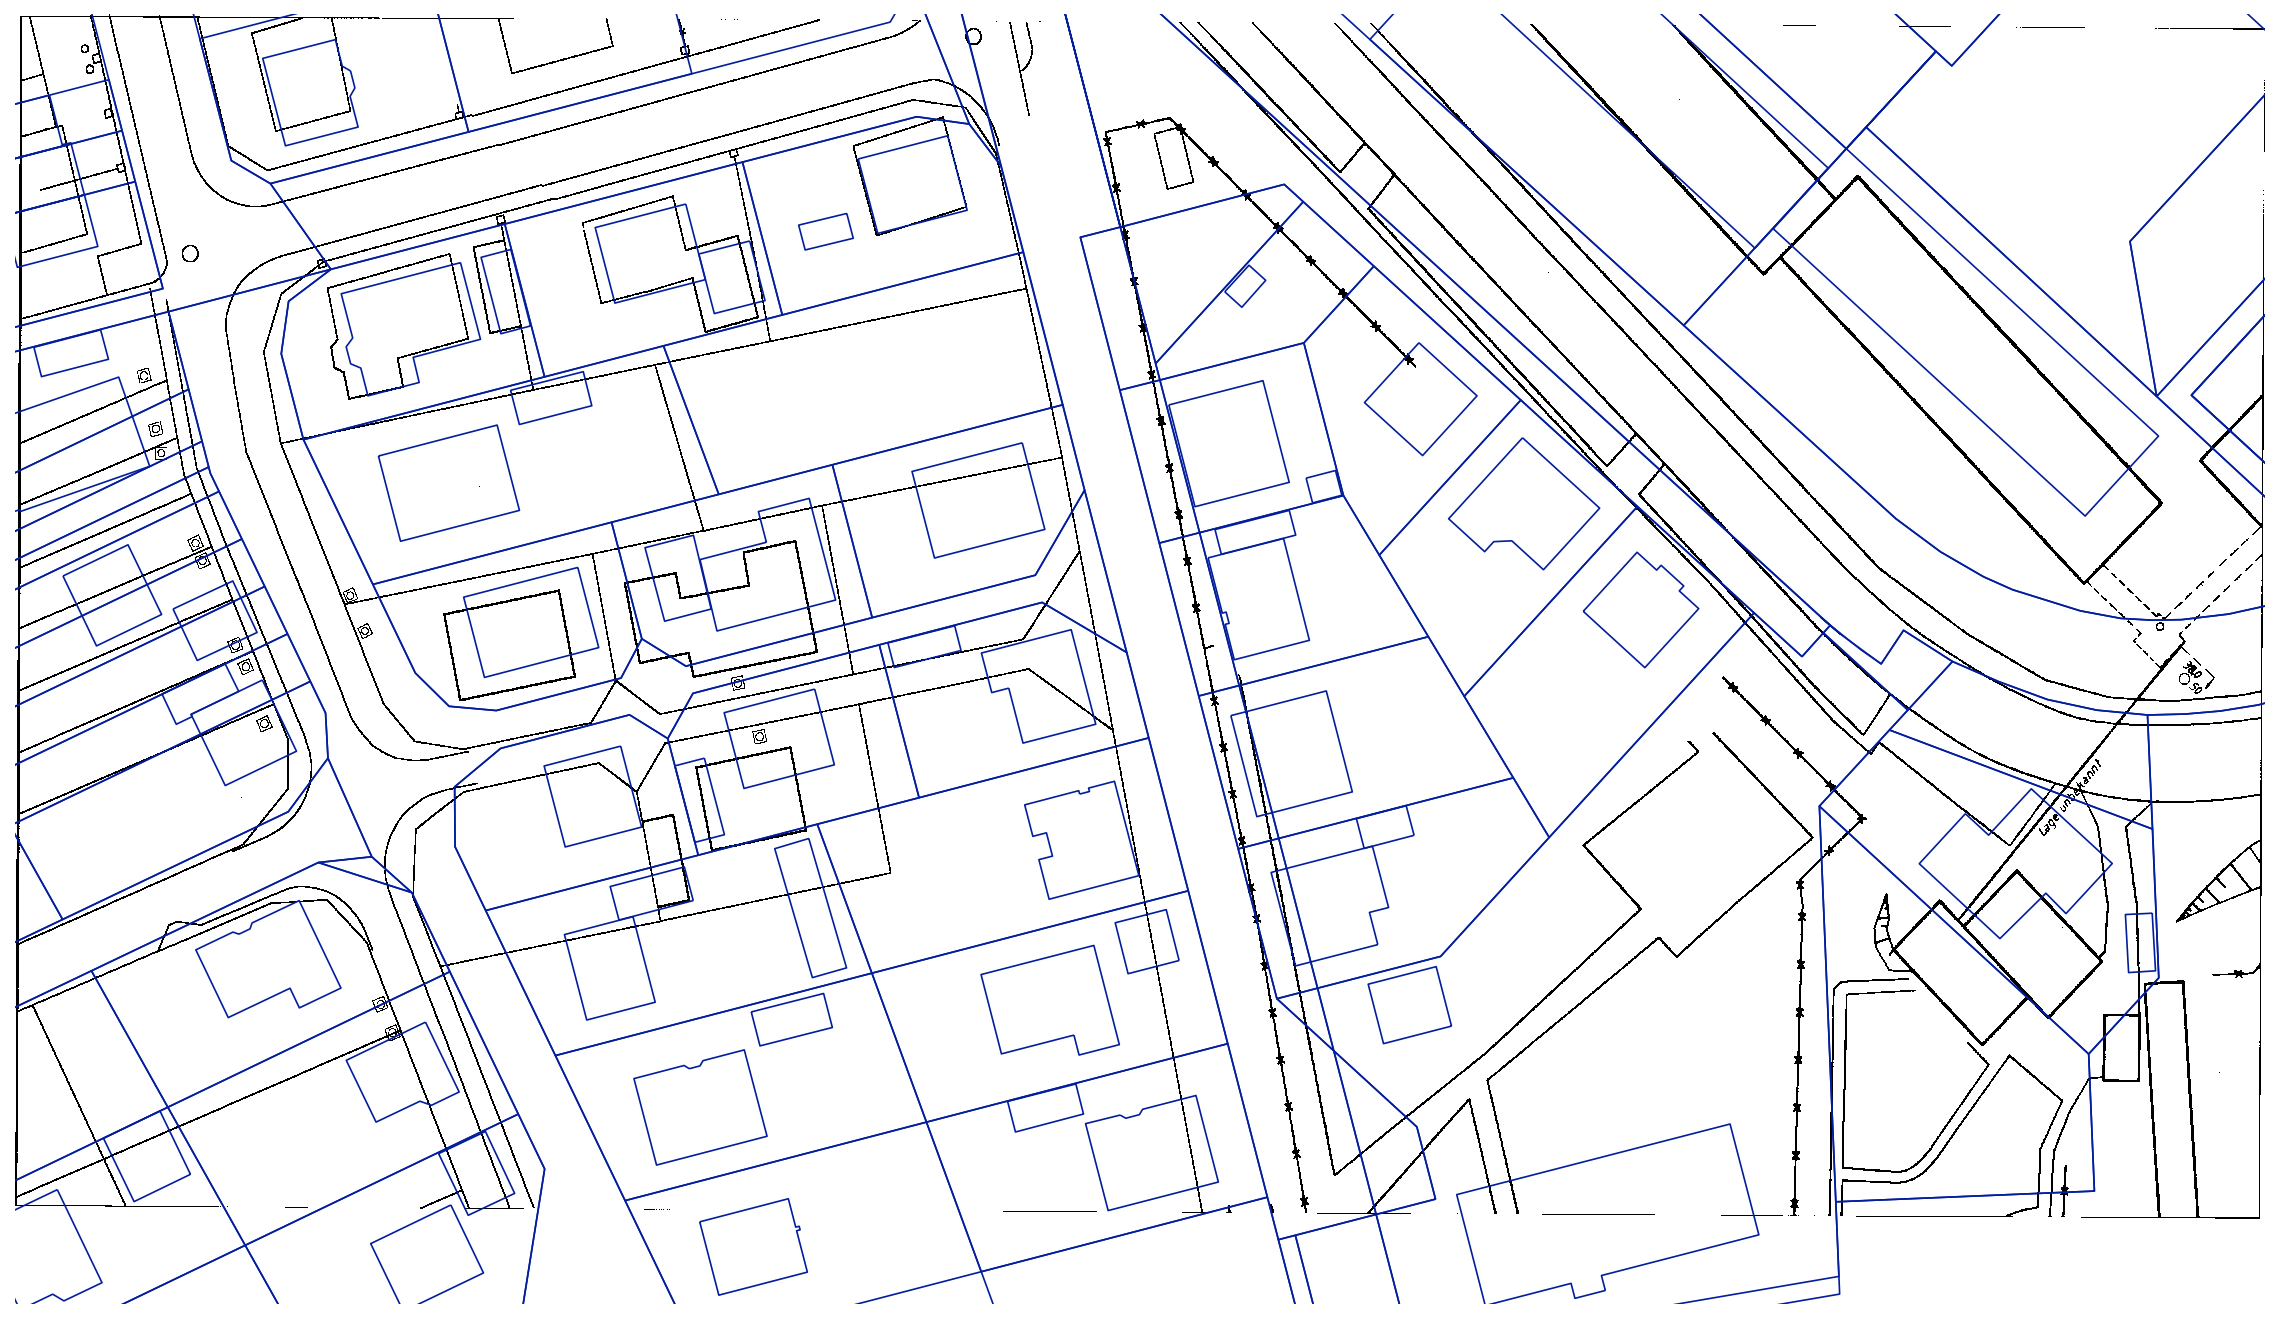

TIF file: 8828ab.tif
Number of intersecting features: 145


In [13]:
# Get LAGEPLAN info once
lageplan_row = stadt_df[stadt_df['layer'] == 'LAGEPLAENE'].iloc[0]
lageplan_polygon = lageplan_row.geometry
lageplan_name = lageplan_row['NAME']
tif_id = lageplan_name.split(prefix)[1]
bounds = lageplan_polygon.bounds

# Filter intersecting features once
intersecting_hu = stadt_df[
    (stadt_df['layer'].isin(['ALKIS_HU', 'ALKIS_FLUR'])) &
    (stadt_df.geometry.intersects(lageplan_polygon))
]

# Common plot settings
def setup_plot(fig, ax):
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    plt.tight_layout(pad=0)

# 1. TIF only
fig1, ax1 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
with rasterio.open(BASE_PATH / "Raster" / f"{tif_id}.tif") as src:
    image = src.read(1)
    ax1.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
setup_plot(fig1, ax1)
plt.savefig(BASE_PATH / "raster.png",
            bbox_inches='tight',
            pad_inches=0,
            dpi=150)
plt.show()

# 2. Vector data only
fig2, ax2 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
intersecting_hu.plot(ax=ax2,
                    facecolor='none',
                    edgecolor='#021e9c',
                    linewidth=0.9)
setup_plot(fig2, ax2)
plt.savefig(BASE_PATH / "alkis.png",
            bbox_inches='tight',
            pad_inches=0,
            dpi=150)
plt.show()
print("saved raster and alkis")
# 3. Combined overlay
fig3, ax3 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=150)
with rasterio.open(BASE_PATH / "Raster" / f"{tif_id}.tif") as src:
    image = src.read(1)
    ax3.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
intersecting_hu.plot(ax=ax3,
                    facecolor='none',
                    edgecolor='#021e9c',
                    linewidth=0.8)
setup_plot(fig3, ax3)
plt.show()

print(f"TIF file: {tif_id}.tif")
print(f"Number of intersecting features: {len(intersecting_hu)}")

## match images

In [4]:
from os.path import join

import cv2
import torch
from matplotlib import pyplot as plt

from gluestick import batch_to_np, numpy_image_to_torch, GLUESTICK_ROOT
from gluestick.drawing import plot_images, plot_lines, plot_color_line_matches, plot_keypoints, plot_matches
from gluestick.models.two_view_pipeline import TwoViewPipeline

Define the configuration and model that we are going to use in our demo:

In [5]:
MAX_N_POINTS, MAX_N_LINES = 1000, 300

# Evaluation config
conf = {
    'name': 'two_view_pipeline',
    'use_lines': True,
    'extractor': {
        'name': 'wireframe',
        'sp_params': {
            'force_num_keypoints': False,
            'max_num_keypoints': MAX_N_POINTS,
        },
        'wireframe_params': {
            'merge_points': True,
            'merge_line_endpoints': True,
        },
        'max_n_lines': MAX_N_LINES,
    },
    'matcher': {
        'name': 'gluestick',
        'weights': str(GLUESTICK_ROOT / 'resources' / 'weights' / 'checkpoint_GlueStick_MD.tar'),
        'trainable': False,
    },
    'ground_truth': {
        'from_pose_depth': False,
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline_model = TwoViewPipeline(conf).to(device).eval()
pipeline_model

/content/GlueStick/gluestick/models/superpoint.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(str(path), map_location='cpu')
/content/GlueStick/g

TwoViewPipeline(
  (extractor): SPWireframeDescriptor(
    (sp): SuperPoint(
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (convPb): Conv2d(256, 65, kernel_size=(1, 1), str

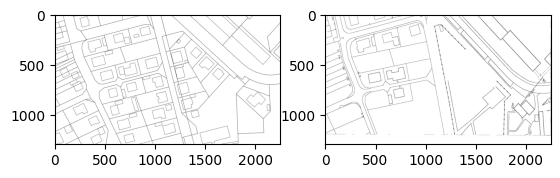

In [17]:
# img = cv2.imread(img_path0, cv2.IMREAD_GRAYSCALE)

gray0 = cv2.imread(str(BASE_PATH / "alkis.png"), 0)
gray1 = cv2.imread(str(BASE_PATH / "raster.png"), 0)

# Plot them using matplotlib
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(gray0, cmap='gray')
axarr[1].imshow(gray1, cmap='gray')

In [18]:
# Convert images into torch and execute GlueStick💥
torch_gray0, torch_gray1 = numpy_image_to_torch(gray0), numpy_image_to_torch(gray1)
torch_gray0, torch_gray1 = torch_gray0.to(device)[None], torch_gray1.to(device)[None]
x = {'image0': torch_gray0, 'image1': torch_gray1}
pred = pipeline_model(x)

In [19]:
print(f"Detected Keypoints: {pred['keypoints0'].shape[1]} img1, {pred['keypoints1'].shape[1]} img2")
print(f"Detected Lines: {pred['lines0'].shape[1]} img1, {pred['lines1'].shape[1]} img2\n")
print(f"Matched {(pred['matches0'] >= 0).sum()} points and {(pred['line_matches0'] >= 0).sum()} lines")

Detected Keypoints: 1498 img1, 1470 img2
Detected Lines: 300 img1, 300 img2

Matched 445 points and 115 lines


Show some matches

In [20]:
pred = batch_to_np(pred)
kp0, kp1 = pred["keypoints0"], pred["keypoints1"]
m0 = pred["matches0"]

line_seg0, line_seg1 = pred["lines0"], pred["lines1"]
line_matches = pred["line_matches0"]

valid_matches = m0 != -1
match_indices = m0[valid_matches]
matched_kps0 = kp0[valid_matches]
matched_kps1 = kp1[match_indices]

valid_matches = line_matches != -1
match_indices = line_matches[valid_matches]
matched_lines0 = line_seg0[valid_matches]
matched_lines1 = line_seg1[match_indices]

## Detected Lines

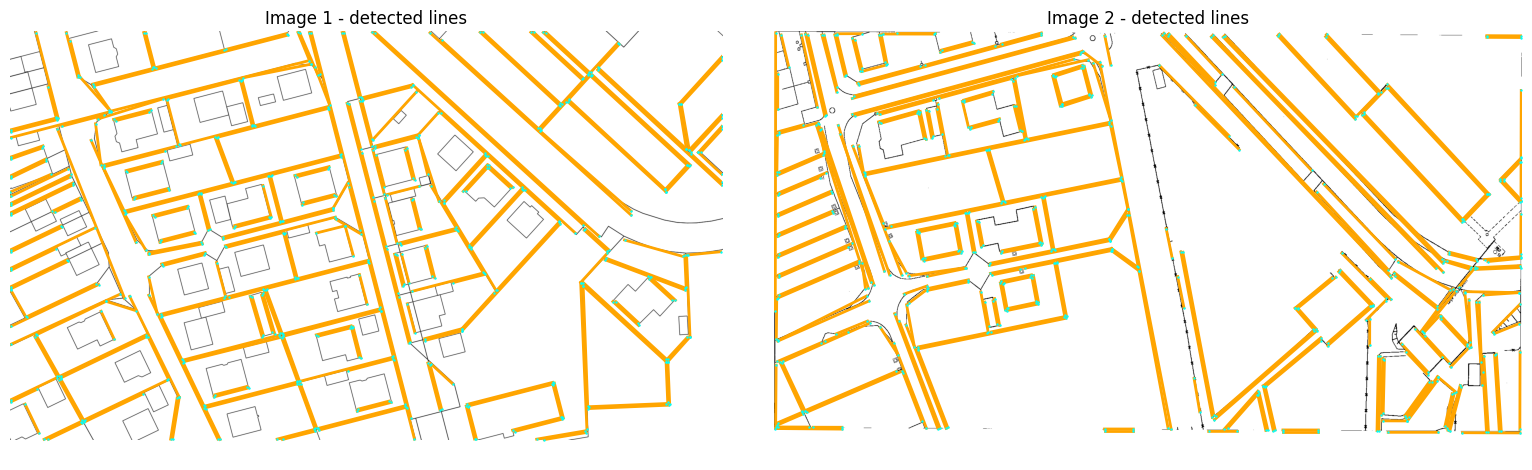

In [21]:
img0, img1 = cv2.cvtColor(gray0, cv2.COLOR_GRAY2BGR), cv2.cvtColor(gray1, cv2.COLOR_GRAY2BGR)
plot_images([img0, img1], ['Image 1 - detected lines', 'Image 2 - detected lines'], pad=0.5)
plot_lines([line_seg0, line_seg1], ps=3, lw=2)

## Detected Points

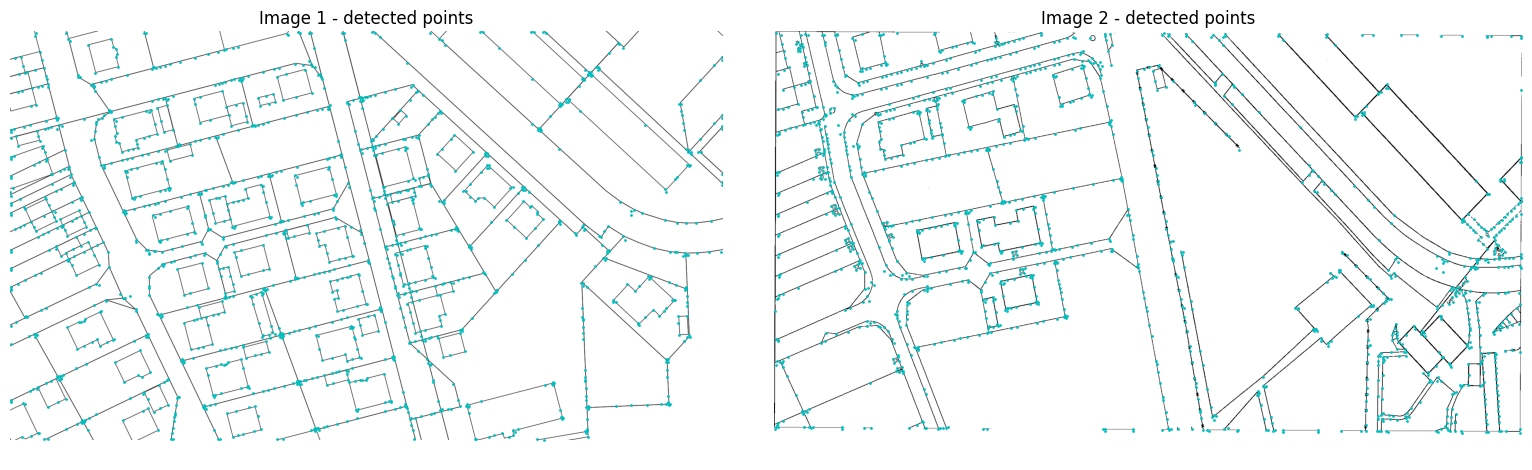

In [22]:
plot_images([img0, img1], ['Image 1 - detected points', 'Image 2 - detected points'], pad=0.5)
plot_keypoints([kp0, kp1], colors='c')

## Matched Lines
(Each match has a different color)

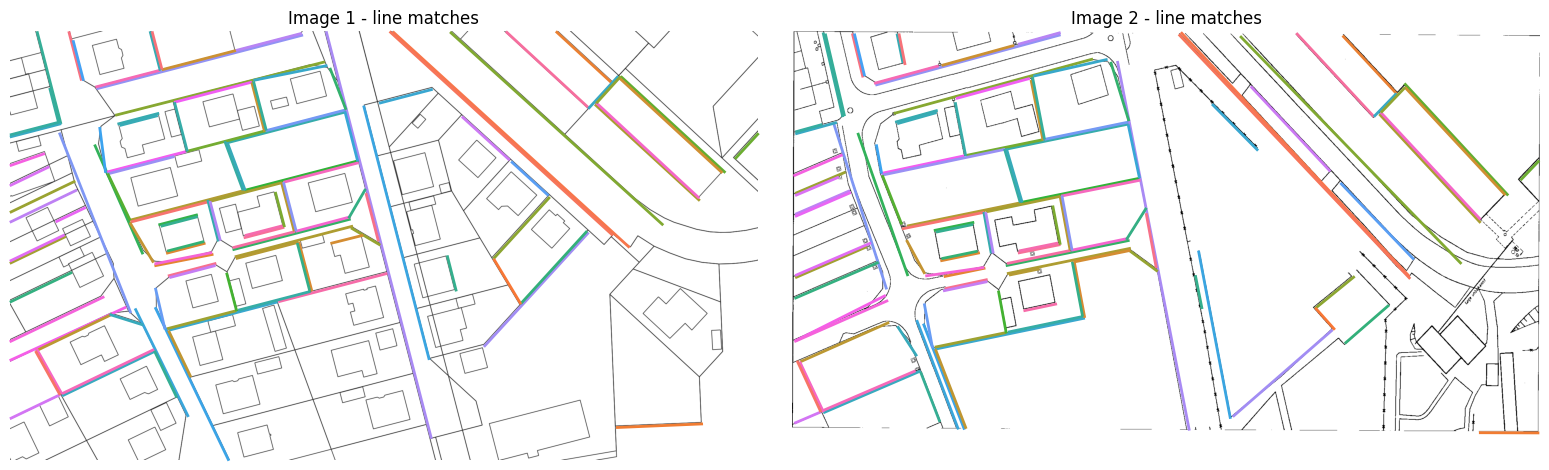

In [23]:
plot_images([img0, img1], ['Image 1 - line matches', 'Image 2 - line matches'], pad=0.5)
plot_color_line_matches([matched_lines0, matched_lines1], lw=2)

## Matched Points

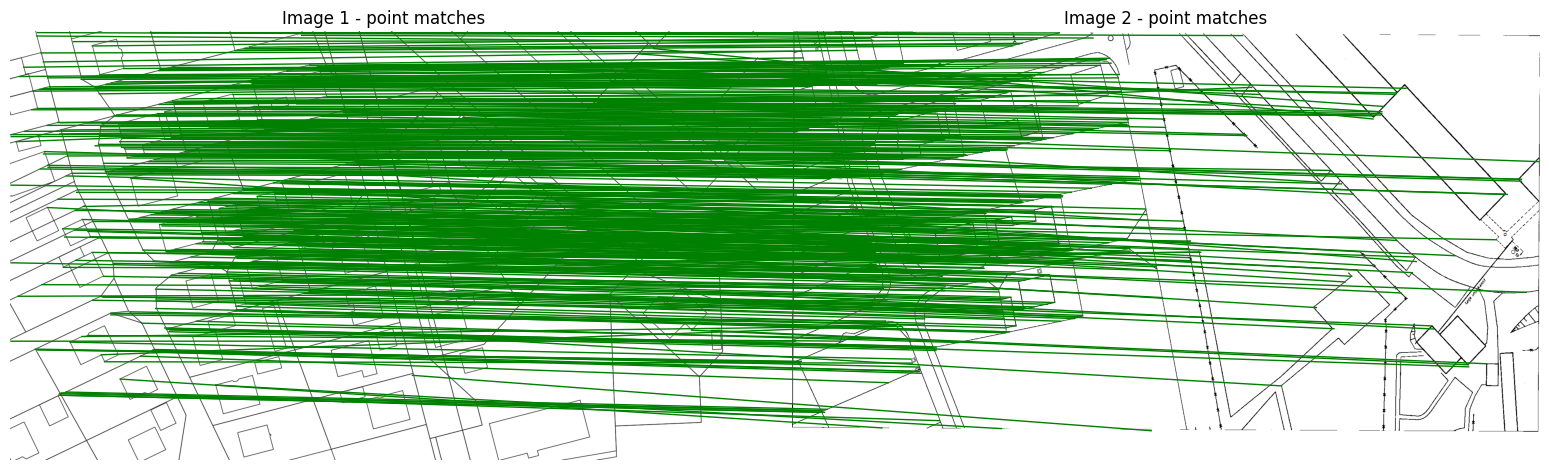

In [24]:
plot_images([img0, img1], ['Image 1 - point matches', 'Image 2 - point matches'], pad=0.5)
plot_matches(matched_kps0, matched_kps1, 'green', lw=1, ps=0)

# Homography estimation

If the scene is nearly a plane, we can estimate a robust homography using both, points and lines

In [ ]:
!sudo apt-get update
!sudo apt-get install -y libceres-dev libeigen3-dev
!pip install git+https://github.com/rpautrat/homography_est.git@17b200d528e6aa8ac61a878a29265bf5f9d36c41

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,309 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Hit:13 https://ppa

In [ ]:
import homography_est as hest

line_seg0 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines0.reshape(-1, 2, 2)]
line_seg1 = [hest.LineSegment(l[0], l[1])
             for l in matched_lines1.reshape(-1, 2, 2)]

tol_px = 1.0
H = hest.ransac_point_line_homography(matched_kps0, matched_kps1, line_seg0, line_seg1, tol_px, False, [], [])

color0 = cv2.cvtColor(cv2.imread(img_path0), cv2.COLOR_BGR2RGBA)
color1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGBA)

warped = cv2.warpPerspective(color1, H, color0.shape[:2][::-1])

plot_images([color0, warped], pad=2.6)
plt.suptitle('Visual alignment of image 2 with image 1')
plt.show()

We can check how well aligned are both images generating a nice transition GIF 😎

In [ ]:
#@title GIF Generation
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
from IPython.display import Video

n_frames = 10
# create samples distribution with different `std` values
frames_indices = np.append(np.arange(n_frames), np.arange(n_frames)[::-1])
pbar = tqdm(frames_indices, desc ="Generating animation", total=len(frames_indices)-1)
# func which will be applied in order to create a video frame
def func(i):
    plt.gca().clear()
    alpha = i / (n_frames - 1)
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(color0, alpha, warped, beta, 0.0)
    plt.gca().imshow(dst)
    plt.axis('off')

fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# create the animation using custom func and its parameters (fargs)
ani = animation.FuncAnimation(fig, func, pbar, interval=100,
                              repeat_delay=250, blit=False)

# save the animation into a specific video format
dst_file = './animation_homography.mp4'
ani.save(dst_file)
plt.close()

# custom html attributes set when lauching the video
Video(dst_file, embed=True, html_attributes="muted loop autoplay")